In [2]:
import pandas as pd
import csv as csv
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
df = pd.read_csv("train.csv").replace("male", 0).replace("female", 1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df["Age"]

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
5       NaN
6      54.0
7       2.0
8      27.0
9      14.0
10      4.0
11     58.0
12     20.0
13     39.0
14     14.0
15     55.0
16      2.0
17      NaN
18     31.0
19      NaN
20     35.0
21     34.0
22     15.0
23     28.0
24      8.0
25     38.0
26      NaN
27     19.0
28      NaN
29      NaN
       ... 
861    21.0
862    48.0
863     NaN
864    24.0
865    42.0
866    27.0
867    31.0
868     NaN
869     4.0
870    26.0
871    47.0
872    33.0
873    47.0
874    28.0
875    15.0
876    20.0
877    19.0
878     NaN
879    56.0
880    25.0
881    33.0
882    22.0
883    28.0
884    25.0
885    39.0
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [4]:
#欠損処理 by median
df["Age"].fillna(df.Age.median(), inplace = True)
df["Age"].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

([array([  80.,   97.,  372.]), array([ 216.,  184.,  491.])],
 array([ 1.        ,  1.66666667,  2.33333333,  3.        ]),
 <a list of 2 Lists of Patches objects>)

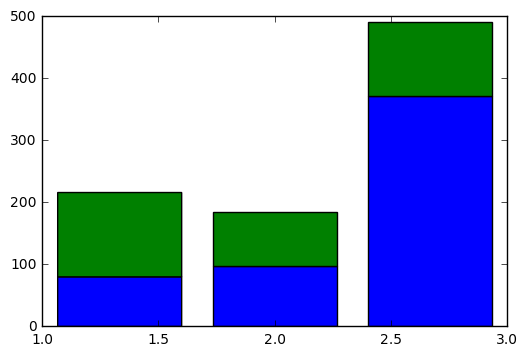

In [5]:
split_data = [] #dataframeをSurvivedが0,1の人で二つのリストに分ける。
for survived in [0, 1]:
    split_data.append(df[df.Survived == survived])
temp = [i["Pclass"].dropna() for i in split_data] #一時的にヒストグラムに居れる変数もSurvivedの0,1で分ける。Split_dataの中をForで回すけど実質二回だけ。
plt.hist(temp, histtype = "barstacked", bins = 3)

In [6]:
split_data[0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",0,28.0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S
12,13,0,3,"Saundercock, Mr. William Henry",0,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",0,39.0,1,5,347082,31.2750,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",1,14.0,0,0,350406,7.8542,NaN,S
16,17,0,3,"Rice, Master. Eugene",0,2.0,4,1,382652,29.1250,NaN,Q
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",1,31.0,1,0,345763,18.0000,NaN,S


In [7]:
split_data[1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.00,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.00,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.00,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.00,1,0,237736,30.0708,NaN,C
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.00,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",1,58.00,0,0,113783,26.5500,C103,S
15,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",1,55.00,0,0,248706,16.0000,NaN,S
17,18,1,2,"Williams, Mr. Charles Eugene",0,28.00,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",1,28.00,0,0,2649,7.2250,NaN,C


In [8]:
#Familiysizeを親族＋子供の数＋本人で算出。同部屋の可能性などを探る。
df["FamiliySize"] = df["SibSp"] + df["Parch"] + 1

In [9]:
df_dropped = df.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis = 1)#関係ない奴、Familysizeに統合された奴は省いたDf作成。

In [10]:
df_dropped

,PassengerId,Survived,Pclass,Sex,Age,FamiliySize
0,1,0,3,0,22.0,2
1,2,1,1,1,38.0,2
2,3,1,3,1,26.0,1
3,4,1,1,1,35.0,2
4,5,0,3,0,35.0,1
5,6,0,3,0,28.0,1
6,7,0,1,0,54.0,1
7,8,0,3,0,2.0,5
8,9,1,3,1,27.0,3
9,10,1,2,1,14.0,2


In [11]:
#上の新しいデータフレームでRF試す。
train_df = df_dropped.values #学習用にArrayに変換
x = train_df[:, 2:6] #ArrayのPclass - FamiliySizeを格納
y = train_df[:, 1:2] #Survivedの被説明変数を格納

In [12]:
# データの標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x_std = scaler.transform(x)

In [13]:
rf = RandomForestClassifier(n_estimators = 100)#インスタンス生成
rf = rf.fit(x_std, y)#学習

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [14]:
#テストデータも同じ処理をしてX_testを作成
df_test = pd.read_csv("test.csv").replace("male", 0).replace("female", 1)
#欠損処理 by median
df_test["Age"].fillna(df.Age.median(), inplace = True)
df_test["FamiliySize"] = df_test["SibSp"] + df_test["Parch"] + 1 #Familiysizeを親族＋子供の数＋本人で算出。同部屋の可能性などを探る。
df_test_dropped = df_test.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis = 1)#関係ない奴、Familysizeに統合された奴は省いたDf作成。
test_df = df_test_dropped.values #学習用にArrayに変換
x_test = test_df[:, 1:5] #ArrayのPclass - FamiliySizeを格納

In [15]:
x_test

array([[  3. ,   0. ,  34.5,   1. ],
       [  3. ,   1. ,  47. ,   2. ],
       [  2. ,   0. ,  62. ,   1. ],
       ..., 
       [  3. ,   0. ,  38.5,   1. ],
       [  3. ,   0. ,  28. ,   1. ],
       [  3. ,   0. ,  28. ,   3. ]])

In [16]:
#モデルにX_test入れて予測
output = rf.predict(x_test)
output

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [17]:
#予測結果とPassIDをZipする
zip_data = zip(df_test["PassengerId"].astype(int), output.astype(int))
predict_data = list(zip_data)
predict_data[0:10]#予測結果の一部を出力。

[(892, 0),
 (893, 0),
 (894, 0),
 (895, 0),
 (896, 0),
 (897, 0),
 (898, 0),
 (899, 0),
 (900, 0),
 (901, 0)]

In [18]:
# テスト値を再読み込みして，rfでクラス分類したカラムを追加
df_out = pd.read_csv("./test.csv")
df_out["Survived"] = output

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./submission_rf.csv",index=False)

In [19]:
df_out

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0.0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,0.0
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0.0
